In [ ]:
pip install sentence-transformers umap-learn scikit-learn matplotlib seaborn pandas numpy

In [ ]:
# Arreglar instalación/import de UMAP en Colab
!pip -q uninstall -y umap
!pip -q install -U umap-learn

# Import correcto (NO uses "import umap")
import umap.umap_ as umap



In [ ]:
#Nuevo notebook para crear Silhoute Score
import numpy as np
import pandas as pd
import optuna
import umap.umap_ as umap
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate

url_dataset = 'https://raw.githubusercontent.com/HiramZ04/Cal-State-UMAP_Clustering/refs/heads/main/palabras_50_sin_acentos.csv'
df = pd.read_csv(url_dataset)

ST_model = SentenceTransformer('all-MiniLM-L6-v2')
ST_Embeddings = ST_model.encode(df['palabra'])

umap_model = umap.UMAP(n_neighbors = 8, min_dist= 0.1, n_components=2, metric = 'cosine')
low_dimension = umap_model.fit_transform(ST_Embeddings)

clustering_model = AgglomerativeClustering(n_clusters = 7, linkage='complete', metric='cosine')
clusters = clustering_model.fit_predict(low_dimension)

table = np.column_stack((df['palabra'],clusters))
print(tabulate(table[:5] ,headers=('Words','Clusters'), tablefmt ='fancy_grid'))


╒═════════╤════════════╕
│ Words   │   Clusters │
╞═════════╪════════════╡
│ cat     │          1 │
├─────────┼────────────┤
│ dog     │          1 │
├─────────┼────────────┤
│ car     │          2 │
├─────────┼────────────┤
│ bus     │          5 │
├─────────┼────────────┤
│ train   │          5 │
╘═════════╧════════════╛


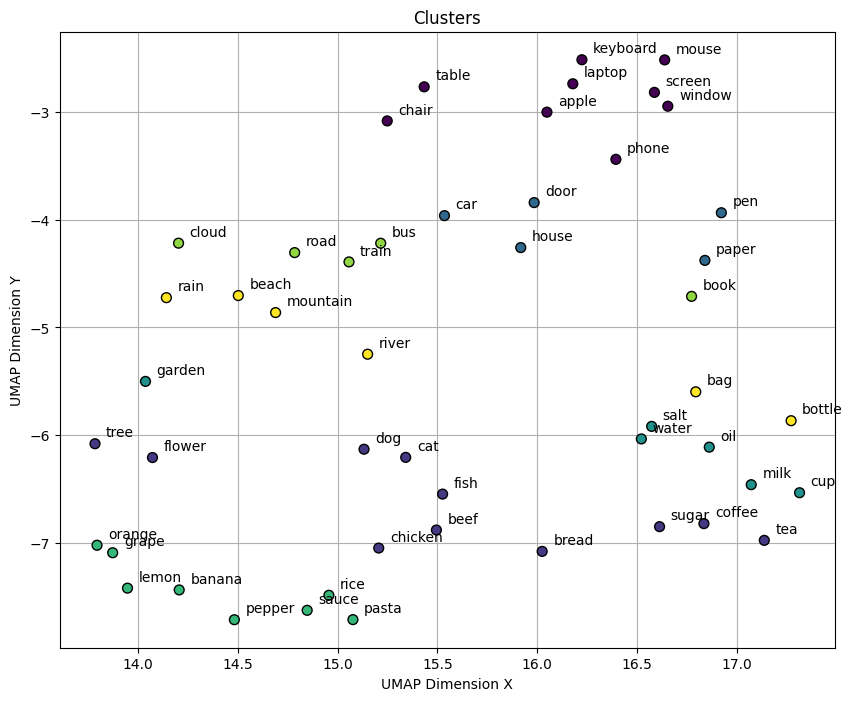

In [ ]:
plt.figure(figsize=(10,8))
plt.grid(True)
plt.scatter(low_dimension[:,0],low_dimension[:,1],c=clusters,s=50,edgecolor='k',zorder=2)
plt.xlabel("UMAP Dimension X")
plt.ylabel("UMAP Dimension Y")
plt.title("Clusters")
for xi, yi, w in zip(low_dimension[:,0],low_dimension[:,1],df['palabra']):
  plt.annotate(w, (xi,yi),xytext=(8, 5), textcoords="offset points")
plt.show()

In [ ]:
#Trying to implement silhoutte scoroe:

s = silhouette_score(low_dimension, clusters, metric='cosine')
print(f'Current Silhouette Coefficient s = {s:.2f}')

scores = []
list_i = []
print("\n\nNext, we are going to print a for loop with the best clusters options from 2 to 21: \n\n")
#We try to get it into a for for different clusters qty
for i in range (2,21):
  clustering_model_i = AgglomerativeClustering(n_clusters = i, linkage='average', metric='cosine')
  clusters_i = clustering_model_i.fit_predict(low_dimension)
  s_i = np.round(silhouette_score(low_dimension, clusters_i, metric='cosine'),4)
  scores.append(s_i)
  list_i.append(i)
  print(f'Silhouette Coefficient {i} = ', s_i)

#We pass the list append to an np.array to use max() function
array = np.array(scores)
print("\nThe highest score of Silhoutte Coeficcient was: ",array.max())
print("With these qty of Clusters: ",array.argmax()+2) #le sumamos 2 porque la lista en realidad se itero desde el 2 al 21 no del 0 al 20


Current Silhouette Coefficient s = 0.76


Next, we are going to print a for loop with the best clusters options from 2 to 21: 


Silhouette Coefficient 2 =  0.7685
Silhouette Coefficient 3 =  0.702
Silhouette Coefficient 4 =  0.6708
Silhouette Coefficient 5 =  0.8023
Silhouette Coefficient 6 =  0.726
Silhouette Coefficient 7 =  0.7185
Silhouette Coefficient 8 =  0.7315
Silhouette Coefficient 9 =  0.7698
Silhouette Coefficient 10 =  0.7979
Silhouette Coefficient 11 =  0.8163
Silhouette Coefficient 12 =  0.8275
Silhouette Coefficient 13 =  0.8063
Silhouette Coefficient 14 =  0.8008
Silhouette Coefficient 15 =  0.7711
Silhouette Coefficient 16 =  0.7748
Silhouette Coefficient 17 =  0.7556
Silhouette Coefficient 18 =  0.7609
Silhouette Coefficient 19 =  0.7559
Silhouette Coefficient 20 =  0.7441

The highest score of Silhoutte Coeficcient was:  0.8275
With these qty of Clusters:  12


Text(0.5, 1.0, 'Silhoutte Score on Number of Clusters')

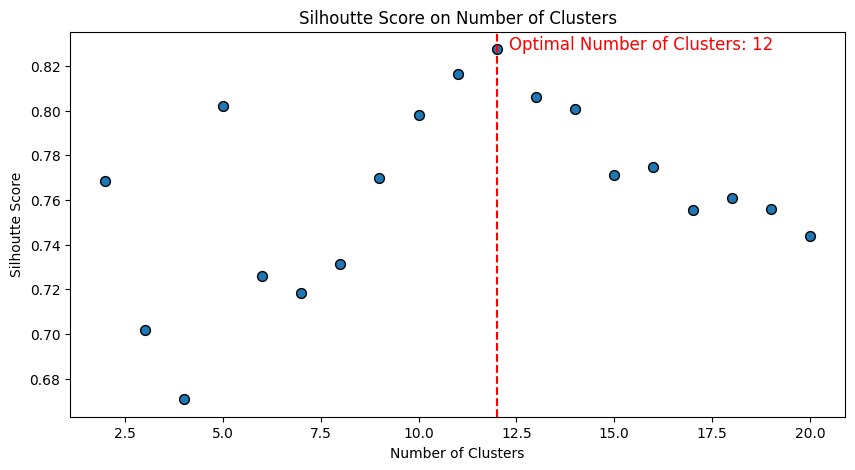

In [ ]:
#Antes de optimizar con OPTUNA graficamos la mejor opcion de clusters en base a Silhoutte Score

plt.figure(figsize=(10,5))
plt.scatter(list_i, array, s=50, edgecolor='k')
plt.axvline(x=array.argmax()+2, linestyle='--', color='red')
plt.annotate(f'Optimal Number of Clusters: {array.argmax()+2}', xy=(array.argmax()+2, array.max()), xytext=(array.argmax()+2.3, array.max()),
            color='red', fontsize=12)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhoutte Score")
plt.title("Silhoutte Score on Number of Clusters")



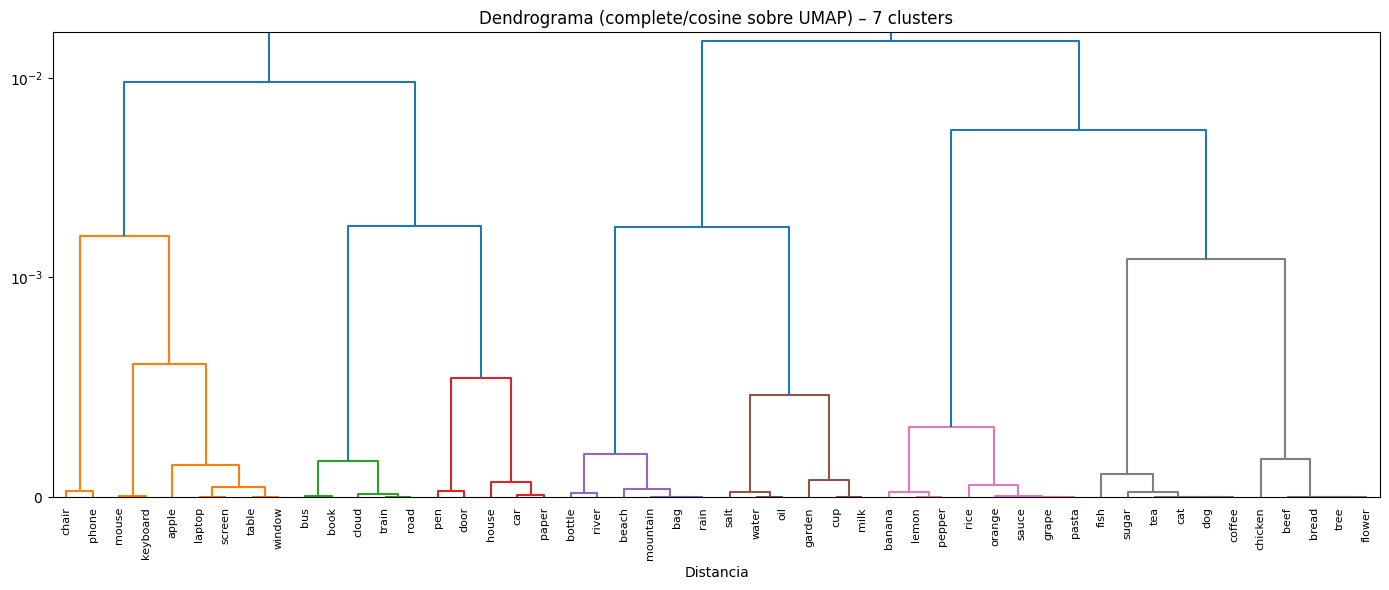

In [ ]:
# Dendrograma sobre UMAP, con estirado de distancias pequeñas y recorte del eje
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

k = 7
GAMMA = 1       # 1.0 = sin cambio; 0.5 = sqrt(x); 0.33 = raíz cúbica (más estirado)
Q = 0.98           # recorta al percentil 98% para quitar colas largas
USE_SYMLOG = True  # escala log cercana a 0 para separar raíces

model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None,
    linkage='complete', metric='cosine',
    compute_distances=True
).fit(low_dimension)

# --- linkage_matrix a partir del modelo ---
counts = np.zeros(model.children_.shape[0])
n = len(model.labels_)
for i, merge in enumerate(model.children_):
    cnt = 0
    for m in merge:
        cnt += 1 if m < n else counts[m - n]
    counts[i] = cnt

# Estira distancias pequeñas de forma monótona (mantiene el orden de fusiones)
dist = np.power(model.distances_.copy(), GAMMA)
Z = np.column_stack([model.children_, dist, counts]).astype(float)

# Umbral para colorear exactamente k clusters (con distancias estiradas)
t = n - k
color_th = dist[t]

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=df['palabra'].astype(str).tolist(),
    orientation='top',
    leaf_font_size=8,
    color_threshold=color_th,
    distance_sort='ascending'
)

ax = plt.gca()
if USE_SYMLOG:
    ax.set_yscale('symlog', linthresh=1e-3)  # separa raíces pegadas a 0
plt.ylim(0, np.quantile(Z[:,2], Q))          # recorta arriba para que se aprecie mejor
plt.title(f'Dendrograma (complete/cosine sobre UMAP) – {k} clusters')
plt.xlabel('Distancia')
plt.tight_layout()
plt.show()


In [ ]:
# Implementando Optuna:
import optuna

# Defino funcion trial donde busco los mejores hiperparametros simultaneamente de UMAP y AgglomerativeClustering ya que los 2 son simultaneos

def objective(trial):
    # Definimos HiperParametros
    min_dist = trial.suggest_float('min_dist', 0.01, 0.2)    # UMAP
    n_neighbors = trial.suggest_int('n_neighbors', 2, 20) # UMAP
    n_clusters = trial.suggest_int('n_clusters', 2, 20)  # Agglomerative Clustering
    agg_linkage = trial.suggest_categorical('agg_linkage', ['average', 'complete']) # Agglomerative Clustering

    # UMAP
    umap_model = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_dist, n_components = 2, metric = 'cosine', random_state=42)
    low_dimension_words = umap_model.fit_transform(ST_Embeddings)

    # Clustering
    clustering_model = AgglomerativeClustering(n_clusters = n_clusters, linkage = agg_linkage, metric = 'cosine')
    clusters = clustering_model.fit_predict(low_dimension_words)

    # Silhoutte Score
    s_score = silhouette_score(low_dimension_words, clusters, metric='cosine')

    return s_score


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_params

[I 2025-09-27 00:10:40,152] A new study created in memory with name: no-name-681edfe2-5c9b-412a-b746-adcdb6cf67e7
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
[I 2025-09-27 00:10:40,259] Trial 0 finished with value: 0.6638744473457336 and parameters: {'min_dist': 0.1406406599744459, 'n_neighbors': 15, 'n_clusters': 5, 'agg_linkage': 'average'}. Best is trial 0 with value: 0.6638744473457336.
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
[I 2025-09-27 00:10:40,339] Trial 1 finished with value: 0.8259903192520142 and parameters: {'min_dist': 0.10954852687408374, 'n_neighbors': 11, 'n_clusters': 16, 'agg_linkage': 'average'}. Best is trial 1 with value: 0.8259903192520142.
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs 

{'min_dist': 0.05664884754928642,
 'n_neighbors': 2,
 'n_clusters': 12,
 'agg_linkage': 'average'}

In [ ]:
# Silhoutte score de los hiperparametros optimizados
import numpy as np
import pandas as pd
import optuna
import umap.umap_ as umap
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from tabulate import tabulate

url_dataset = 'https://raw.githubusercontent.com/HiramZ04/Cal-State-UMAP_Clustering/refs/heads/main/palabras_50_sin_acentos.csv'
df_opt = pd.read_csv(url_dataset)

ST_model_opt = SentenceTransformer('all-MiniLM-L6-v2')
ST_Embeddings_opt = ST_model_opt.encode(df_opt['palabra'])

umap_optimized = umap.UMAP(n_neighbors = 2, min_dist= 0.05664884754928642, n_components=2, metric = 'cosine')
low_dimension_opt = umap_optimized.fit_transform(ST_Embeddings_opt)

clustering_model_opt = AgglomerativeClustering(n_clusters = 12, linkage='average', metric='cosine')
clusters_opt = clustering_model_opt.fit_predict(low_dimension_opt)

table_opt = np.column_stack((df_opt['palabra'],clusters_opt))
print(tabulate(table_opt[:5] ,headers=('Words','Clusters'), tablefmt ='fancy_grid'))

s_opt = silhouette_score(low_dimension_opt, clusters_opt, metric='cosine')
print(f'Current Silhouette Coefficient s = {s_opt:.2f}')


╒═════════╤════════════╕
│ Words   │   Clusters │
╞═════════╪════════════╡
│ cat     │          8 │
├─────────┼────────────┤
│ dog     │          8 │
├─────────┼────────────┤
│ car     │          2 │
├─────────┼────────────┤
│ bus     │          2 │
├─────────┼────────────┤
│ train   │          2 │
╘═════════╧════════════╛
Current Silhouette Coefficient s = 0.97


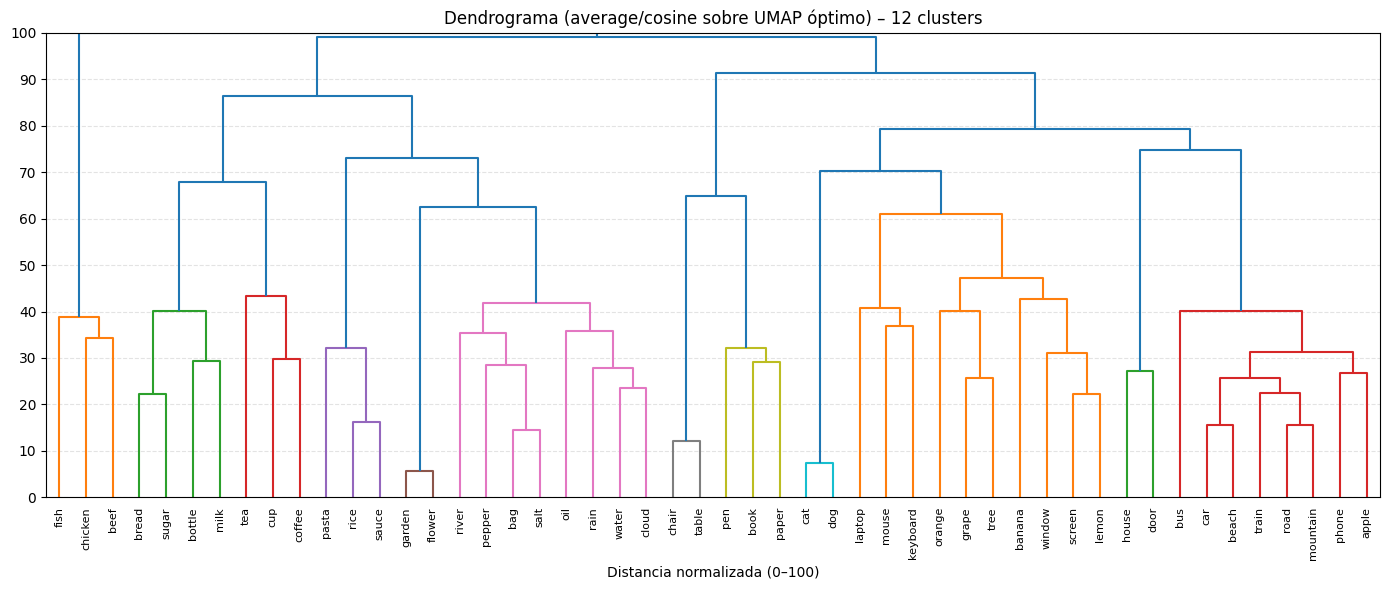

In [ ]:
# Dendrograma con "distancia bonita" (0–100, estirada) sobre tu UMAP óptimo
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import numpy as np
import matplotlib.pyplot as plt

k = 12  # tus clusters óptimos

model = AgglomerativeClustering(
    distance_threshold=0, n_clusters=None,
    linkage='average', metric='cosine',
    compute_distances=True
).fit(low_dimension_opt)  # usa el UMAP optimizado

# linkage_matrix (Z) con distancias "bonitas"
n = len(model.labels_)
counts = np.zeros(model.children_.shape[0])
for i, merge in enumerate(model.children_):
    cnt = 0
    for m in merge:
        cnt += 1 if m < n else counts[m - n]
    counts[i] = cnt

dist = model.distances_.copy()
dist = np.power(dist, 0.1)          # estira lo pequeño (prueba 0.4 o 0.33 si quieres más)
dist = (dist / dist.max()) * 100.0  # escala 0–100

Z = np.column_stack([model.children_, dist, counts]).astype(float)

# umbral para colorear exactamente k clusters (en la escala "bonita")
t = n - k
color_th = dist[t]

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=df_opt['palabra'].astype(str).tolist(),
    orientation='top',
    leaf_font_size=8,
    color_threshold=color_th,
    distance_sort='ascending'
)
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.35)
plt.title(f'Dendrograma (average/cosine sobre UMAP óptimo) – {k} clusters')
plt.xlabel('Distancia normalizada (0–100)')
plt.tight_layout()
plt.show()


# Conclusion:
Hasta ahorita tenemos una funcion sin optimizar que nos da ( **0.76** ) de silhoutte score.
Tambien tenemos una funcion optimizada que nos da ( **0.97** ) de silhoutte score. Creo que hasta ahorita tenemos una funcion de optimizacion muy volatil, no estamos seguros si el score es real porque es muy bueno